In [56]:
import torch
import matplotlib.pyplot as plt
import ternary
import numpy as np

from torch.utils.data import DataLoader
from IPython.display import clear_output

from ensemblecalibration.nn_training.train import train_mlp
from ensemblecalibration.nn_training.model import MLPCalW, MLPDataset
from ensemblecalibration.nn_training.losses import SKCELoss
from ensemblecalibration.calibration.experiments import experiment_h0_feature_dependency, new_experiment_h0
from ensemblecalibration.calibration.calibration_estimates.helpers import calculate_pbar
from ensemblecalibration.calibration.config import config_p_value_analysis
from ensemblecalibration.calibration.plot_functions import plot_scatterplot_ternary
from ensemblecalibration.calibration.p_value_analysis import npbe_test_vaicenavicius


### Evaluation of training an MLP to predict optimal convex combination of ensemble classifier models:


Define parameters:

In [53]:
N_INST_TRAIN = 5000
N_INST_TEST = 1000
N_CLASSES = 3
N_ENS = 10
N_EPOCHS = 10
N_CLASSES = 3
LR = 0.001
BATCH_SIZE = 64
HIDDEN_DIM = 32


generate training and test data, initialise dataset: use setting where a different prior parameter is sampled for each ensemble,
but the same is used for every instance.

In [60]:
p_probs_train, y_labels, l_weights = new_experiment_h0(N_INST_TRAIN, N_ENS, N_CLASSES,uct=1, feature_dependent=True)

p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train, reshape=True, n_dims=2)
dataset_train = MLPDataset(P=p_probs_train, y=y_labels)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)


(5000,)

training loop_ plot real and predicted "optimal" classifier probabilities during training

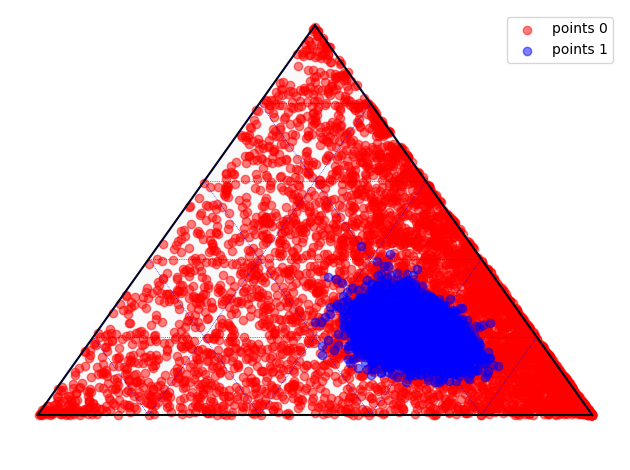

Epoch: 9 train loss: 3.325328696565164e-07


In [55]:
model = MLPCalW(in_channels=N_CLASSES, hidden_dim=HIDDEN_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_train = np.zeros(N_EPOCHS)
loss = SKCELoss()

for epoch in range(N_EPOCHS):
    loss_epoch = []
    model.train()
    for i, (p_probs, y_labels) in enumerate(loader_train):
        p_probs = p_probs.float()
        weights_l = model(p_probs)
        l = loss(p_probs, weights_l, y_labels)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        loss_epoch.append(l.item())
    loss_n = sum(loss_epoch)/(len(loader_train))
    loss_train[epoch] = loss_n

    clear_output(wait=True)
    # plot precited and real probabiility scores
    l_weights_calc = model(torch.from_numpy(p_probs_train).float())
    p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train, reshape=True, n_dims=2)
    plot_scatterplot_ternary([p_bar, p_bar_calc], ["red", "blue"], scale=1)
    plt.show()
    print(f"Epoch: {epoch} train loss: {loss_n}")

In [10]:
model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS)

Epoch: 0 train loss: 1.1924362678681312e-09
Epoch: 1 train loss: 1.1828205938657304e-09
Epoch: 2 train loss: 1.1734795234277592e-09
Epoch: 3 train loss: 1.164992140872369e-09
Epoch: 4 train loss: 1.1573284028235062e-09
Epoch: 5 train loss: 1.1500501638618191e-09
Epoch: 6 train loss: 1.1430680043663736e-09
Epoch: 7 train loss: 1.1363642544591114e-09
Epoch: 8 train loss: 1.1300779017287153e-09
Epoch: 9 train loss: 1.1241078195424053e-09


calculate predicted probailities with found c.c.

In [11]:
l_weights_calc = model(torch.from_numpy(p_probs_train).float())
p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train, reshape=True, n_dims=2)
p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train, reshape=True, n_dims=2)

difference in values of statistics:

In [12]:
val_miscal = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights, p_probs_train, y_labels, config_p_value_analysis["SKCEul"]["params"], True)

val_miscal_calc = config_p_value_analysis["SKCEul"]["params"]["obj_lambda"](l_weights_calc.detach().numpy(), p_probs_train, y_labels, config_p_value_analysis["SKCEul"]["params"], True)

print(val_miscal)
print(val_miscal_calc)

0.00030101155047485955
8.318690755629944e-07


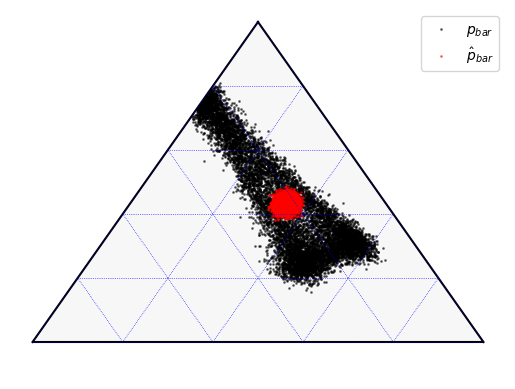

In [13]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

#tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')

tax.scatter([tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))], marker='o', color='red', s= 1, alpha=0.5, label='$\hat{p}_{bar}}$')

tax.legend()

tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.show()

In [14]:
p_probs_train, y_labels = experiment_h0_feature_dependency(N_INST_TRAIN, N_ENS, N_CLASSES, 0.01)

In [15]:
p_probs_train, y_labels, l_weights = new_experiment_h0(N_INST_TRAIN, N_ENS, N_CLASSES, feature_dependent=True)
dataset_train = MLPDataset(P=p_probs_train, y=y_labels)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

model, loss_train = train_mlp(dataset_train=dataset_train, loss=loss, n_epochs=N_EPOCHS)

Epoch: 0 train loss: 7.228340915033364e-11
Epoch: 1 train loss: 7.144949123660308e-11
Epoch: 2 train loss: 7.064121840869141e-11
Epoch: 3 train loss: 6.986351366804499e-11
Epoch: 4 train loss: 6.911975667400926e-11
Epoch: 5 train loss: 6.839761979596652e-11
Epoch: 6 train loss: 6.769353277303754e-11
Epoch: 7 train loss: 6.70314893632882e-11
Epoch: 8 train loss: 6.637669657055662e-11
Epoch: 9 train loss: 6.575038392367247e-11


In [62]:
l_weights_calc = model(torch.from_numpy(p_probs_train).float())
p_bar = calculate_pbar(weights_l=l_weights, P=p_probs_train, reshape=True, n_dims=2)
p_bar_calc = calculate_pbar(weights_l=l_weights_calc.detach().numpy(), P=p_probs_train, reshape=True, n_dims=2)

# compare p-values of Vaicenavicius test
dec, p_val_real, stat = npbe_test_vaicenavicius(p_bar, y_labels, params=config_p_value_analysis["SKCEul"]["params"])

In [64]:
_, p_val_calc, stat_calc = npbe_test_vaicenavicius(p_bar_calc, y_labels, params=config_p_value_analysis["SKCEul"]["params"])

In [65]:
p_val_calc

0.998

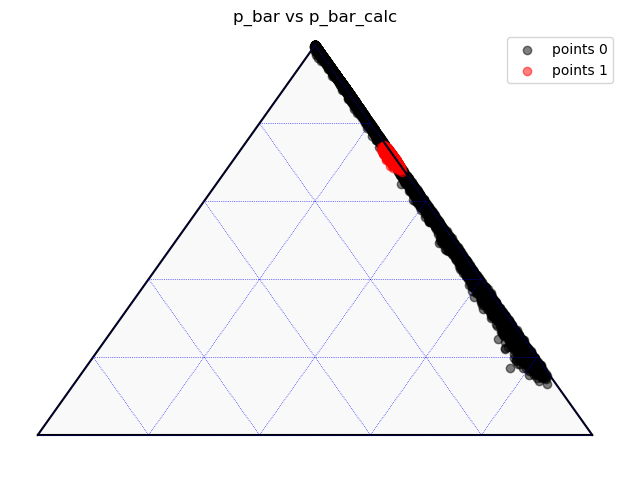

In [17]:
list_points = [p_bar, p_bar_calc]
list_cols = ['black', 'red']
fig = plot_scatterplot_ternary(list_points, list_cols=list_cols, title='p_bar vs p_bar_calc')

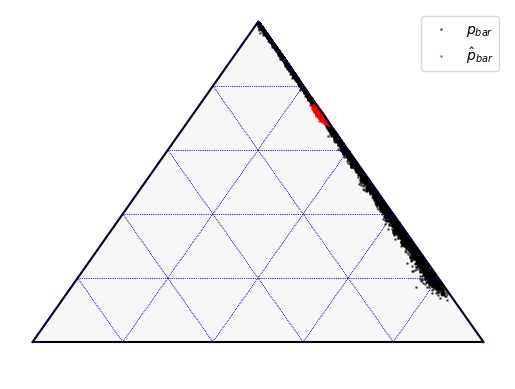

In [18]:
fig, tax = ternary.figure(scale=1)
tax.boundary(linewidth=1.5)

tax.gridlines(color="black", multiple=.2, linewidth=.5)
tax.gridlines(color="blue", multiple=.2, linewidth=.5)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

tax.scatter([tuple(p_bar[i]) for i in range(len(p_bar))], marker='o', color='black', s= 1, alpha=0.5, label='$p_{bar}}$')

tax.scatter([tuple(p_bar_calc[i]) for i in range(len(p_bar_calc))], marker='o', color='red', s= 1, alpha=0.5, label='$\hat{p}_{bar}}$')

tax.legend()

tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

plt.show()